In [1]:
# Installing Catboost and vecstack (a stacking library)
!pip install catboost
!pip install vecstack

  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19880 sha256=6a1adb91310aa2ab545eaf5a6b5268b2d8745aaef51ca16173842a6d7e2b4142
  Stored in directory: c:\users\yrovs\appdata\local\pip\cache\wheels\17\89\0b\21d5484cbf713c95b641ec1bdc40dd7ae798cbdea2337e3535
Successfully built vecstack


In [3]:
!pip install lightgbm


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso

# LGBM, XGB, CTB
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Stacking library
from vecstack import StackingTransformer

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
all_df = pd.concat([train,test]).reset_index()

In [6]:
print("train shape",train.shape)
print("test shape:",test.shape)
print("full dataset shape",all_df.shape)

train shape (3865, 80)
test shape: (890, 79)
full dataset shape (4755, 81)


In [7]:
# Percent of NA in dataset
all_df.isna().sum().sort_values()/len(all_df)

index                                                                        0.000000
galactic year                                                                0.000000
galaxy                                                                       0.000000
existence expectancy index                                                   0.001262
existence expectancy at birth                                                0.001262
                                                                               ...   
Intergalactic Development Index (IDI), male, Rank                            0.696951
Adjusted net savings                                                         0.699054
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total    0.700736
Private galaxy capital flows (% of GGP)                                      0.703470
Gender Inequality Index (GII)                                                0.711251
Length: 81, dtype: float64

In [8]:
all_num = all_df._get_numeric_data()
print(all_num[all_num<0].sum())

index                                                                           0.000000
galactic year                                                                   0.000000
existence expectancy index                                                      0.000000
existence expectancy at birth                                                   0.000000
Gross income per capita                                                      -126.906522
                                                                                ...     
Adjusted net savings                                                        -1359.504992
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total      -1.860236
Private galaxy capital flows (% of GGP)                                     -2495.540553
Gender Inequality Index (GII)                                                   0.000000
y                                                                               0.000000
Length: 80, dtype: fl

(array([7.830e+02, 2.018e+03, 3.510e+02, 1.450e+02, 2.120e+02, 1.730e+02,
        7.700e+01, 3.000e+01, 3.100e+01, 2.100e+01, 1.300e+01, 1.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([0.01303645, 0.04657526, 0.08011407, 0.11365288, 0.14719169,
        0.1807305 , 0.21426931, 0.24780812, 0.28134693, 0.31488574,
        0.34842455, 0.38196336, 0.41550217, 0.44904098, 0.48257979,
        0.5161186 , 0.54965741, 0.58319622, 0.61673503, 0.65027385,
        0.68381266]),
 <BarContainer object of 20 artists>)

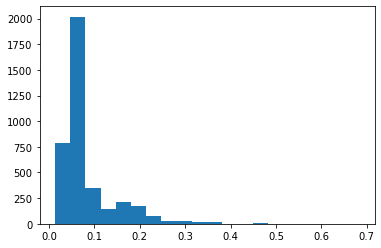

In [9]:
plt.hist(train.y,bins=20)  #Exploring the target variable

(array([2.000e+00, 5.000e+00, 7.000e+00, 3.400e+01, 5.300e+01, 1.050e+02,
        2.090e+02, 1.910e+02, 1.000e+02, 1.880e+02, 1.900e+02, 4.700e+02,
        8.160e+02, 1.043e+03, 2.860e+02, 7.000e+01, 4.600e+01, 3.300e+01,
        1.600e+01, 1.000e+00]),
 array([0.38007129, 0.57806802, 0.77606475, 0.97406148, 1.17205821,
        1.37005494, 1.56805167, 1.76604839, 1.96404512, 2.16204185,
        2.36003858, 2.55803531, 2.75603204, 2.95402876, 3.15202549,
        3.35002222, 3.54801895, 3.74601568, 3.94401241, 4.14200913,
        4.34000586]),
 <BarContainer object of 20 artists>)

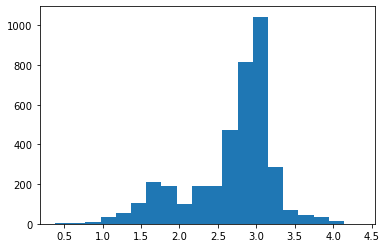

In [10]:
plt.hist(-np.log(train.y),bins=20)


((array([-3.56878042, -3.32933007, -3.1971417 , ...,  3.1971417 ,
          3.32933007,  3.56878042]),
  array([0.01303645, 0.0159289 , 0.01635177, ..., 0.55048368, 0.67683339,
         0.68381266])),
 (0.05270964942740439, 0.0827731321037617, 0.8305914610877568))

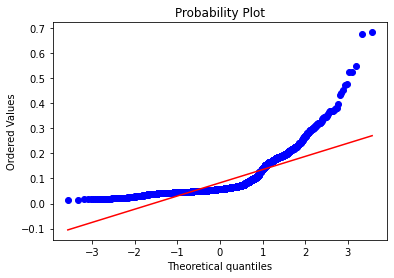

In [11]:
# QQ Plot: always useful ;)
from scipy.stats import probplot

probplot(train.y,dist="norm",plot=plt)

Andromeda Galaxy (M31)


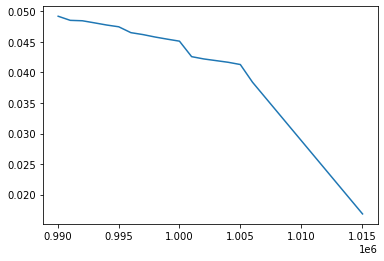

Andromeda I


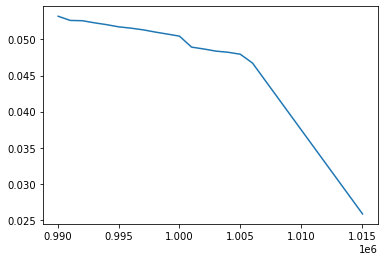

Andromeda II


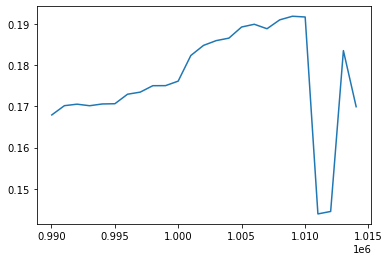

Andromeda III


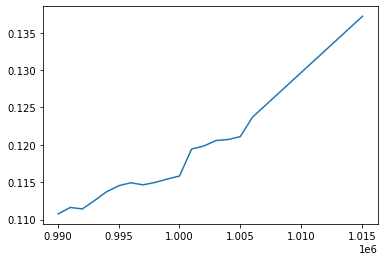

Andromeda IX


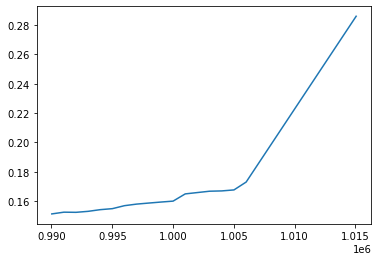

Andromeda V


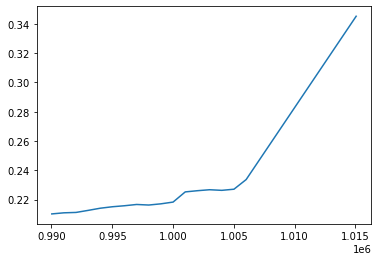

Andromeda VIII


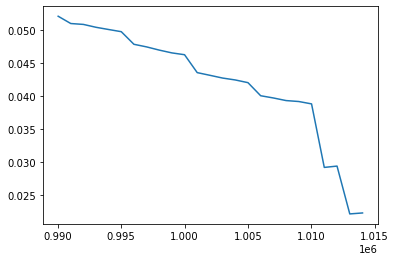

Andromeda X


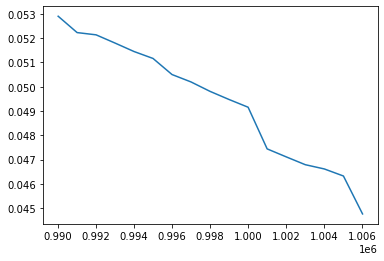

Andromeda XI


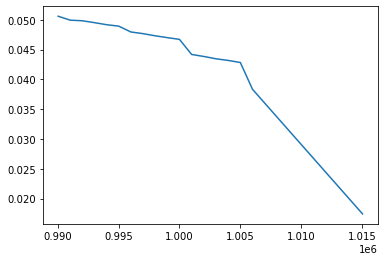

Andromeda XII


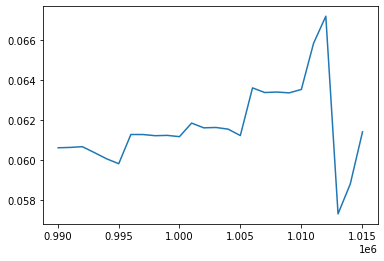

Andromeda XIX[60]


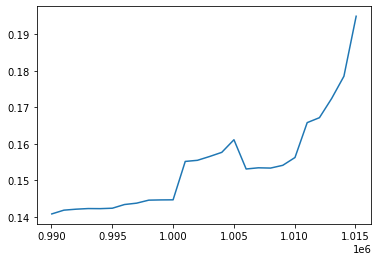

Andromeda XV


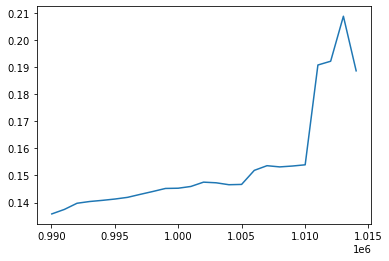

Andromeda XVII


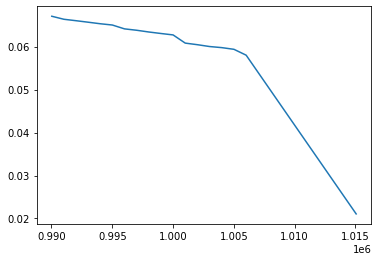

Andromeda XVIII[60]


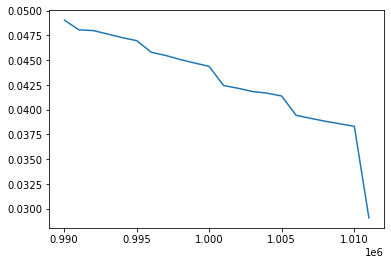

Andromeda XX


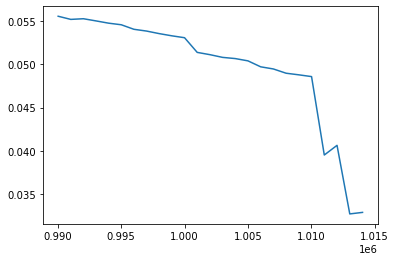

Andromeda XXIII


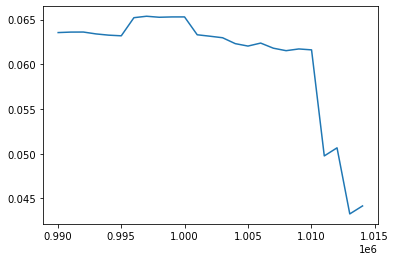

Andromeda XXII[57]


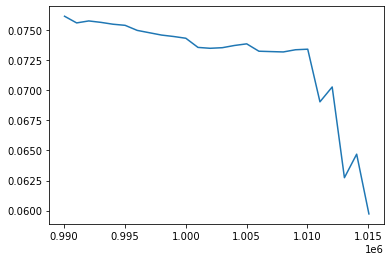

Andromeda XXIV


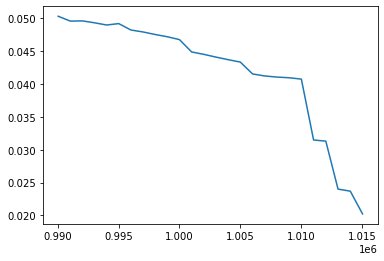

Andromeda XXIX


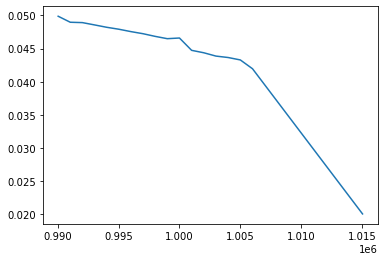

Andromeda XXI[57]


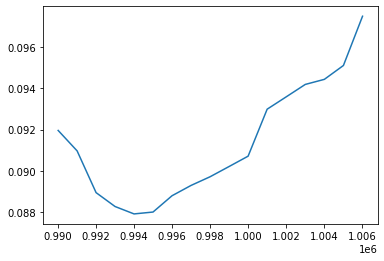

Andromeda XXV


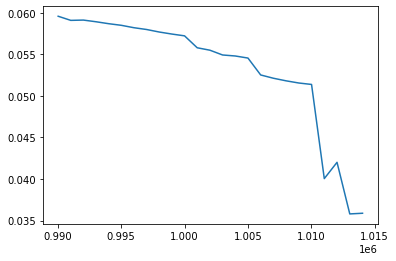

Andromeda XXVI


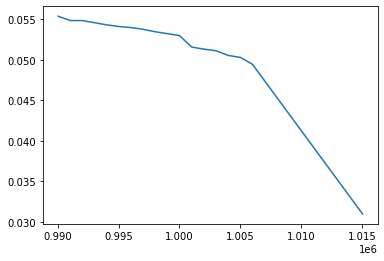

Andromeda XXVIII


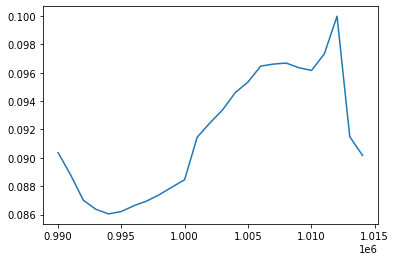

Antlia 2


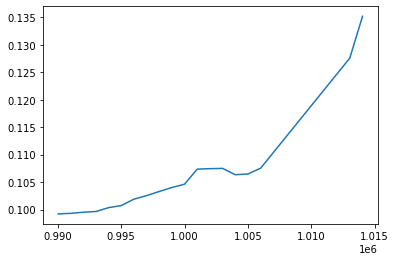

Antlia B


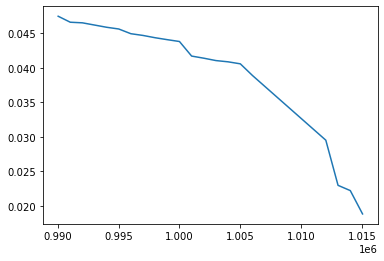

Antlia Dwarf


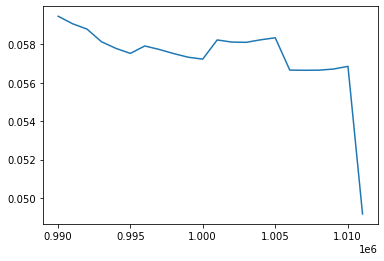

Aquarius Dwarf Galaxy (DDO 210)


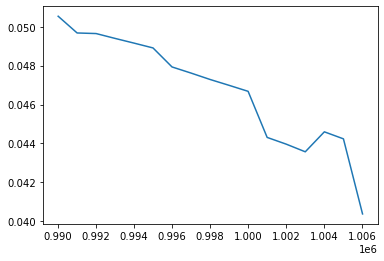

Aquarius II


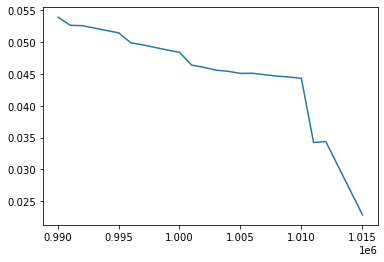

Barnard's Galaxy (NGC 6822)


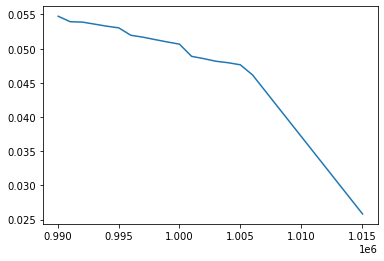

Boötes I


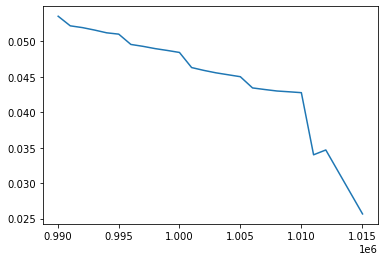

Boötes II


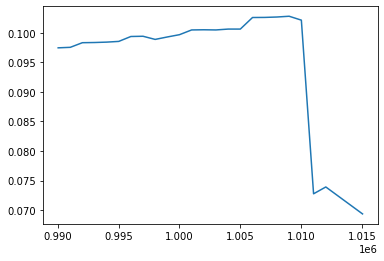

Boötes III


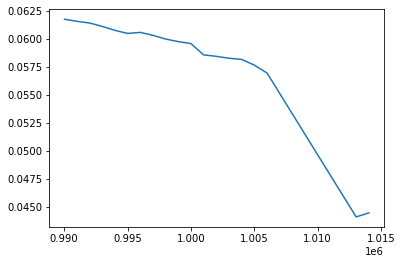

Boötes IV


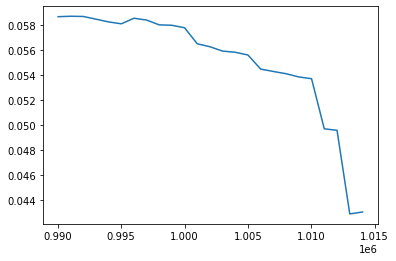

Camelopardalis B


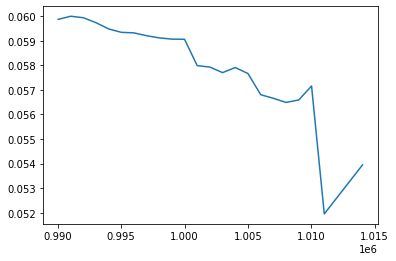

Canes Venatici I Dwarf


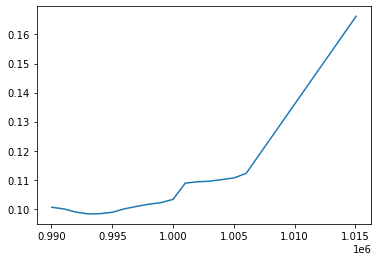

Canes Venatici II Dwarf


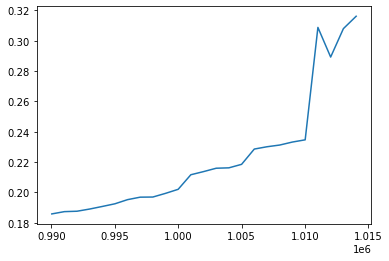

Carina Dwarf (E206-G220)


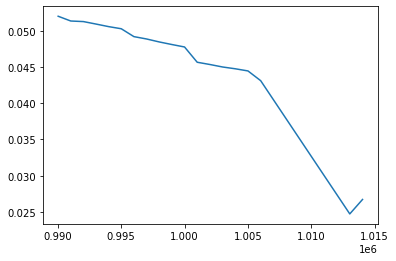

Carina II


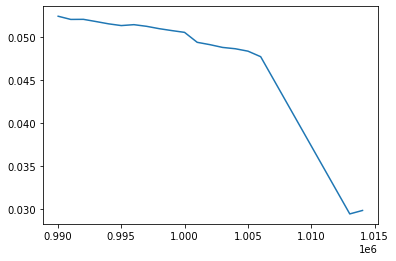

Carina III


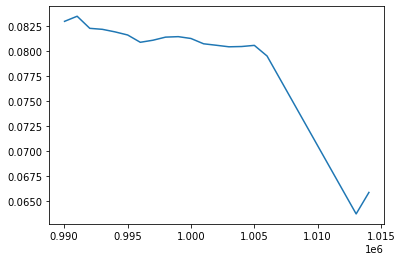

Cas 1 (KK98 19)


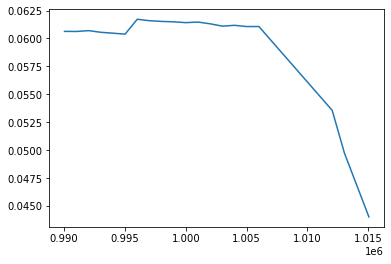

Cassiopeia Dwarf (Cas dSph, Andromeda VII)


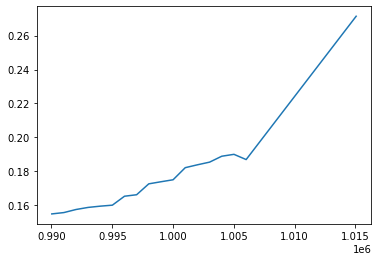

Cassiopeia II (Andromeda XXX)


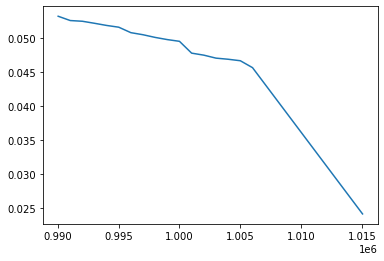

Cassiopeia III (Andromeda XXXII)


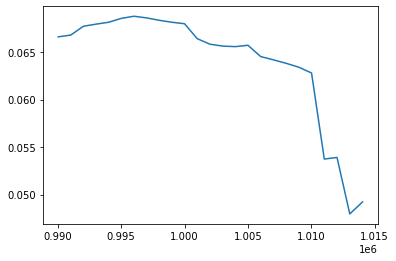

Cetus Dwarf


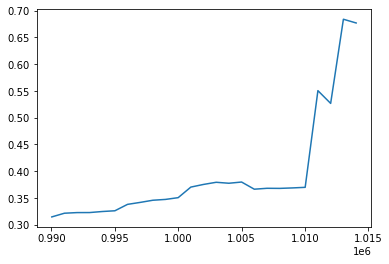

Cetus III


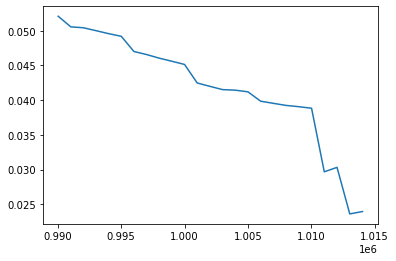

Columba I


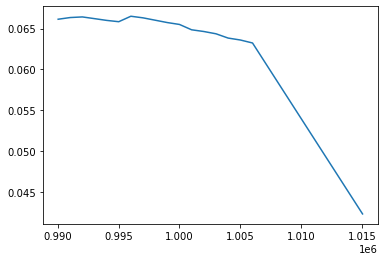

Coma Berenices Dwarf


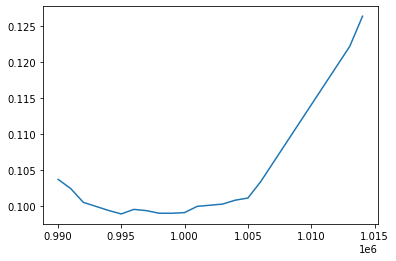

Crater II


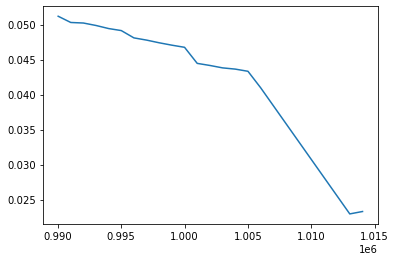

DDO 99 (UGC 6817)


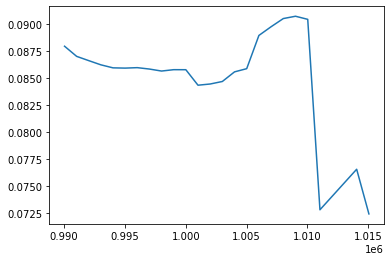

Donatiello I


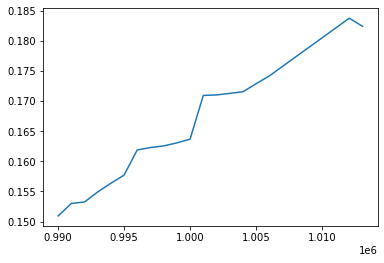

Draco Dwarf (DDO 208)


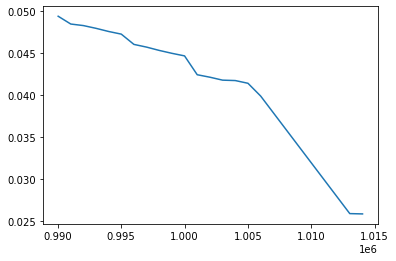

Draco II


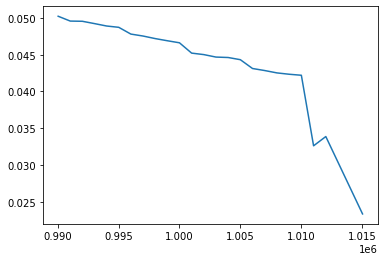

Dwingeloo 1


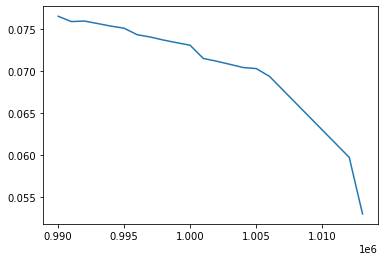

Dwingeloo 2


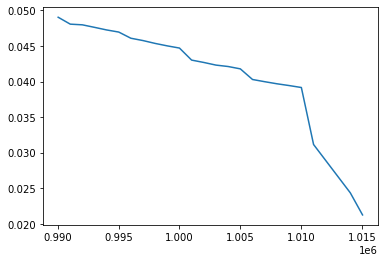

ESO 274-01[70]


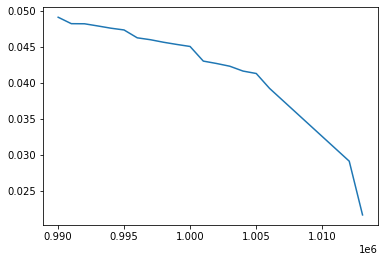

ESO 294-010


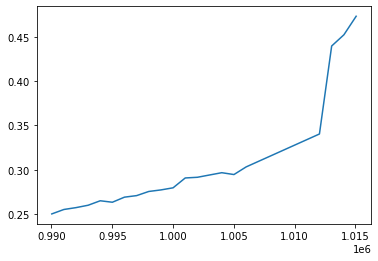

ESO 321-014[70]


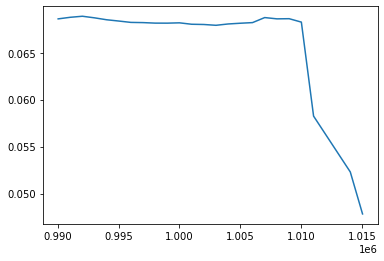

ESO 325-11


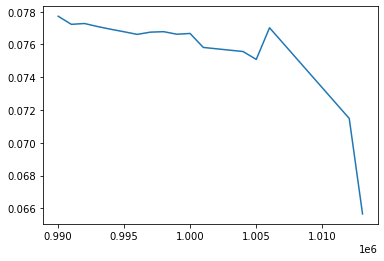

ESO 383-087 (ISG 39)


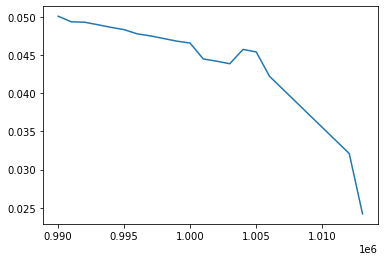

ESO 410-G005


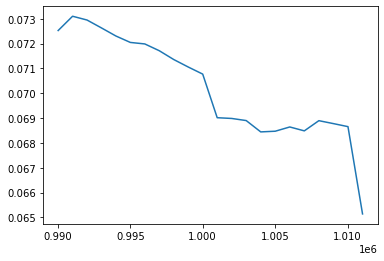

ESO 540-030 (KDG 2)


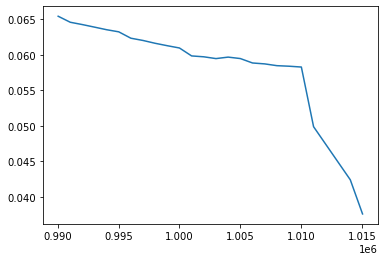

ESO 540-032


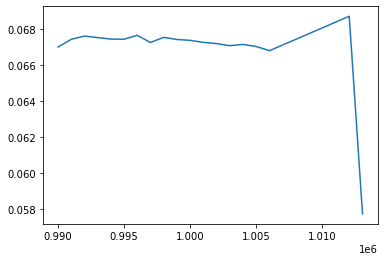

Eridanus II


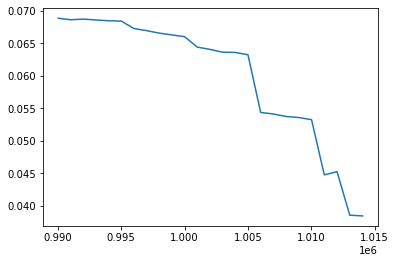

FM2000 1


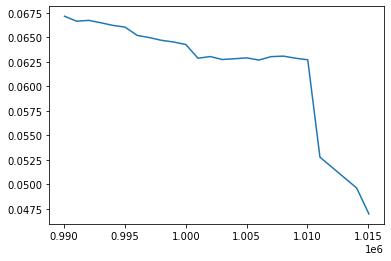

Fornax Dwarf (E356-G04)


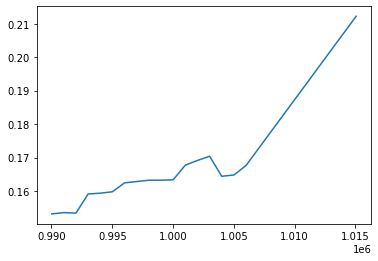

GR 8 (DDO 155)


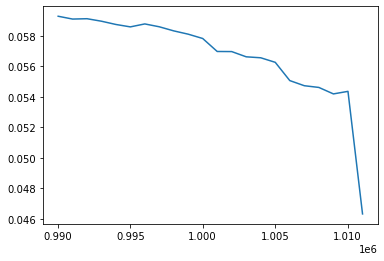

Grus I


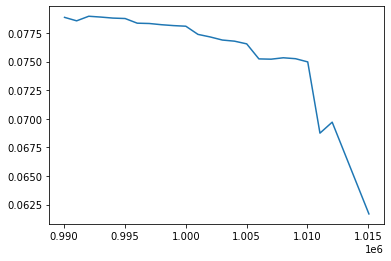

Grus II


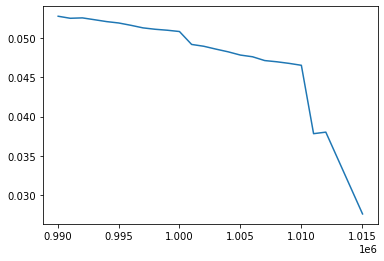

HIPASS J1247-77


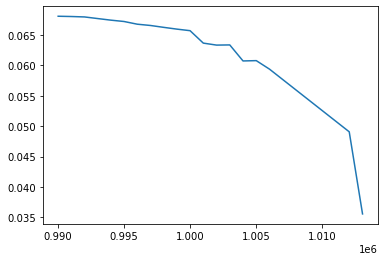

HIZSS 003


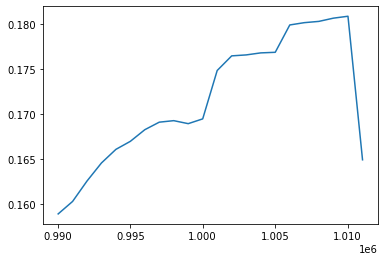

Hercules Dwarf


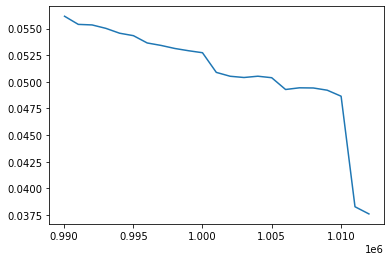

Holmberg II (DDO 50, UGC 4305)


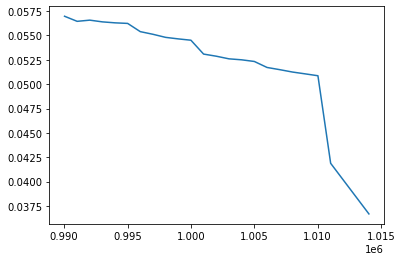

Horologium I


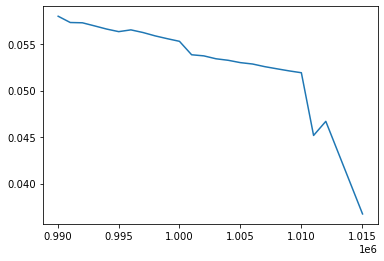

Horologium II


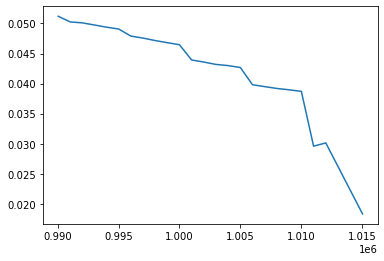

Hydra II


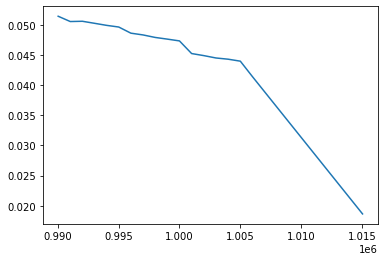

Hydrus I


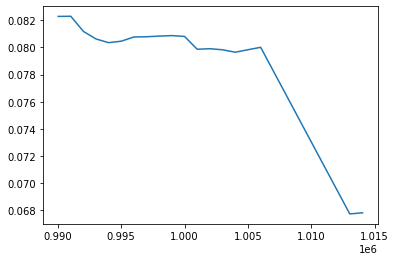

IC 10 (UGC 192)


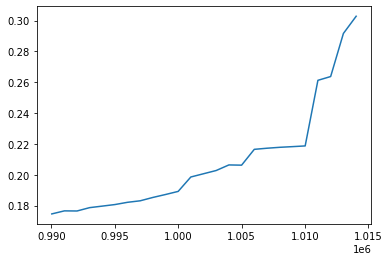

IC 1613 (UGC 668)


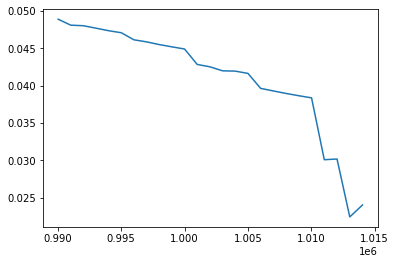

IC 3104


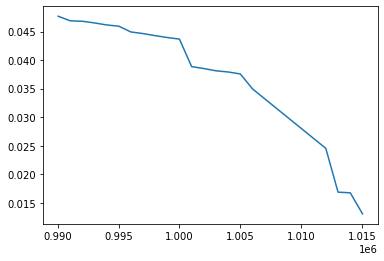

IC 342


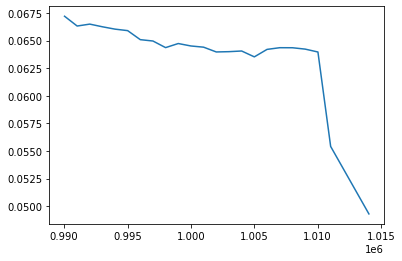

IC 4662 (ESO 102-14)


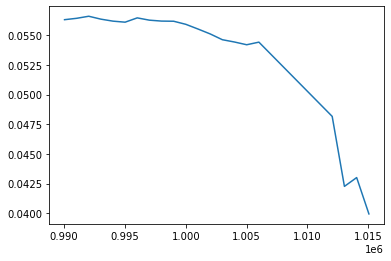

IC 5152


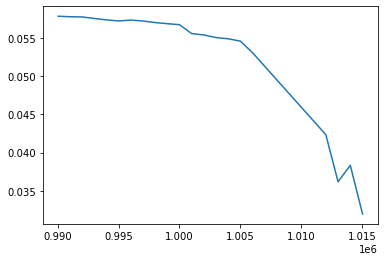

Indus II


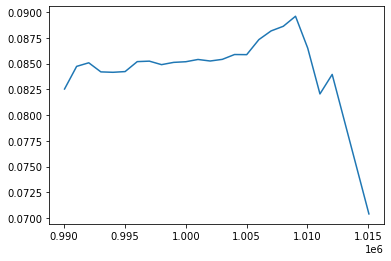

KK98 35


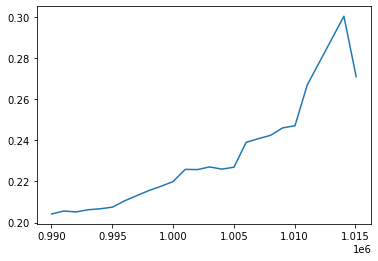

KK98 77


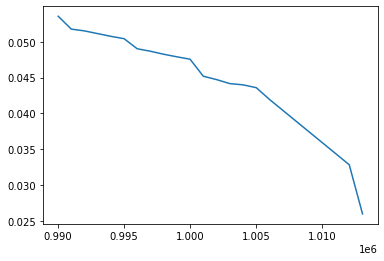

KKH 11 (ZOAG G135.74-04.53)


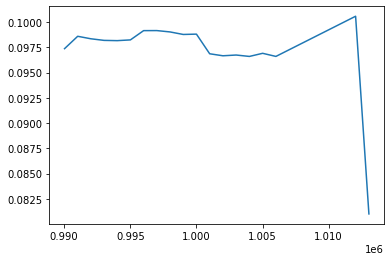

KKH 12


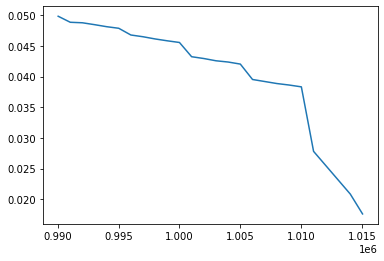

KKH 37 (Mai 16)


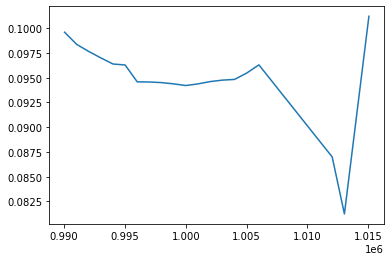

KKR 03 (KK98 230)


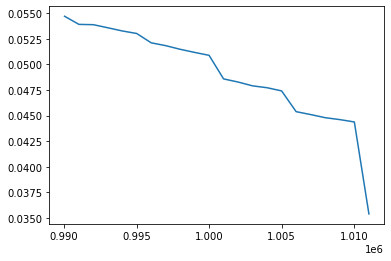

KKR 25


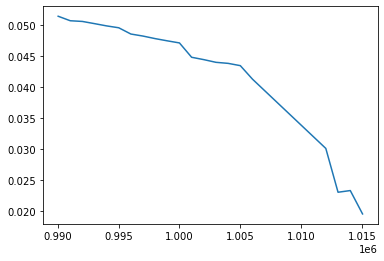

KKh 060


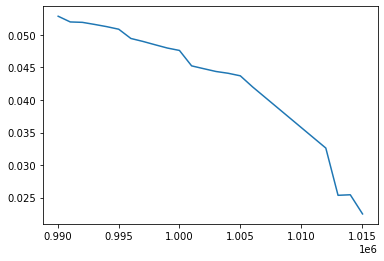

KKh 086


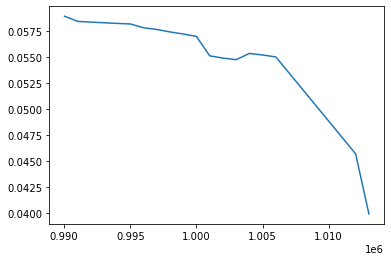

KKh 98


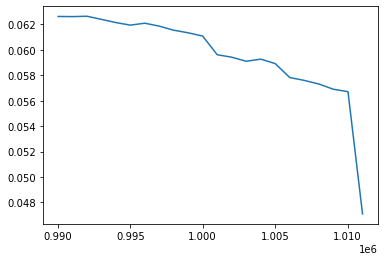

KKs 3


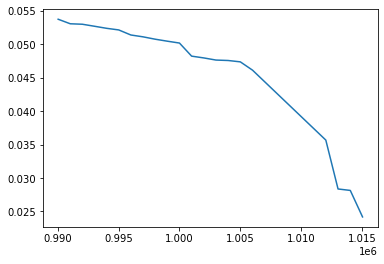

KUG 1210+301B (KK98 127)


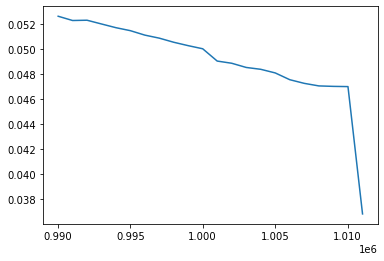

Lacerta I (Andromeda XXXI)


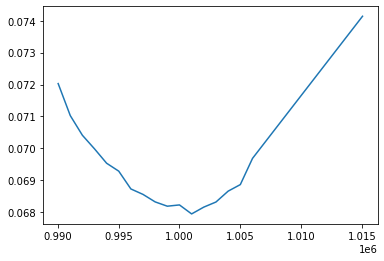

Large Magellanic Cloud (LMC)


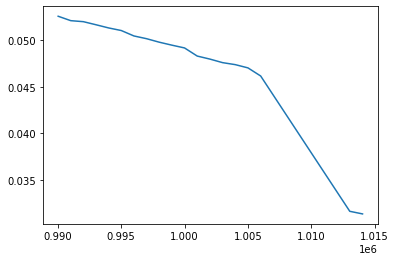

Leo A (Leo III, DDO 69)


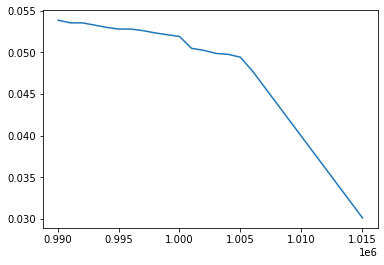

Leo I Dwarf (DDO 74, UGC 5470)


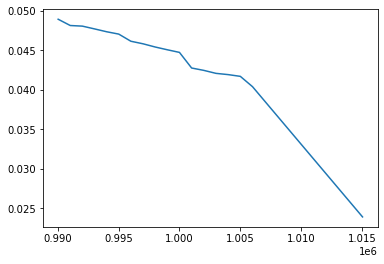

Leo II Dwarf (Leo B, DDO 93)


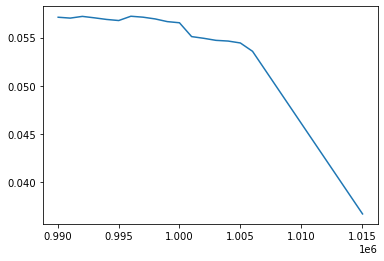

Leo IV Dwarf


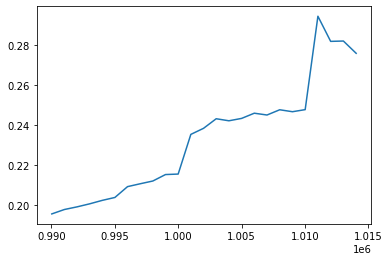

Leo P


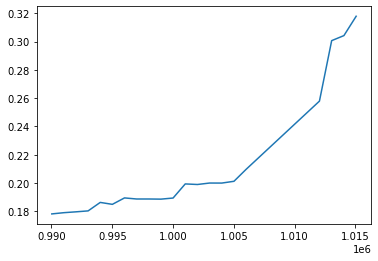

Leo T Dwarf


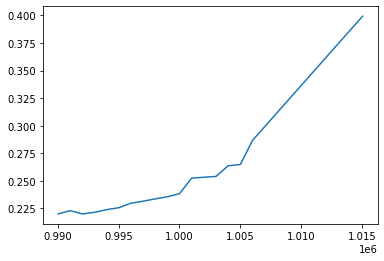

Leo V Dwarf


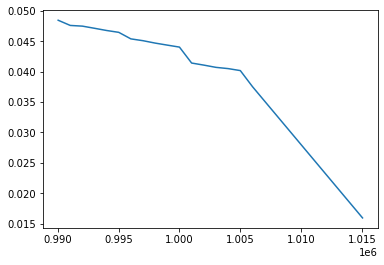

M110 (NGC 205)


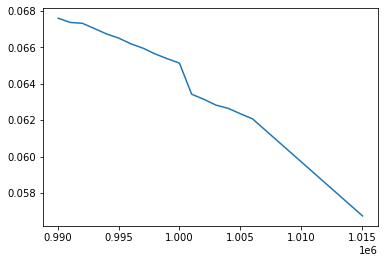

M32 (NGC 221)


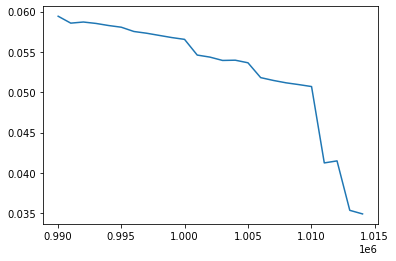

MB 1 (KK98 21)


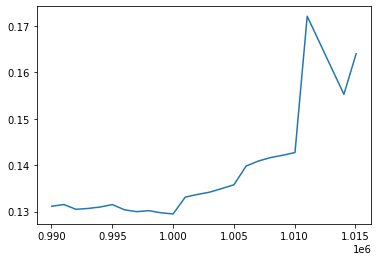

MB 3


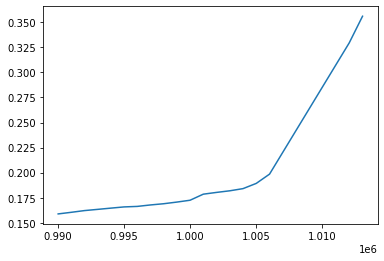

Maffei 1


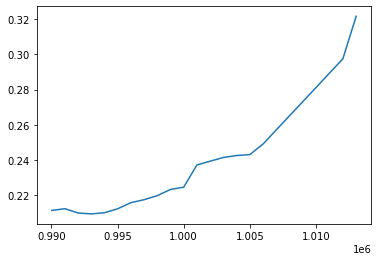

Maffei 2


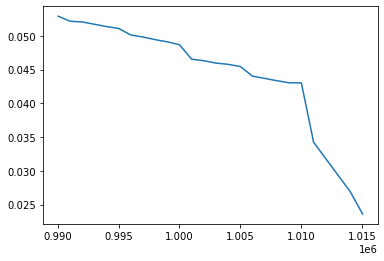

NGC 147 (DDO 3)


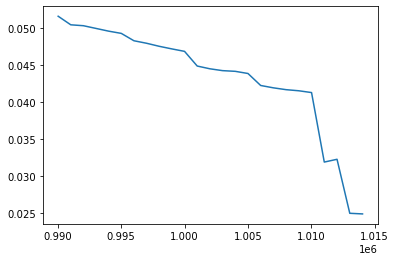

NGC 1560


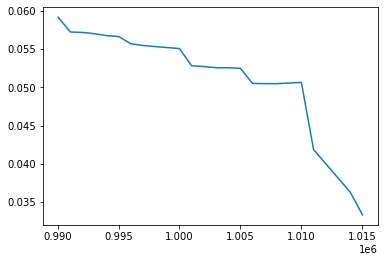

NGC 1569 (UGC 3056)


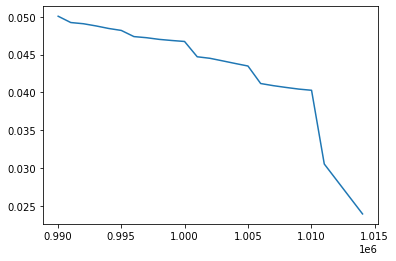

NGC 185


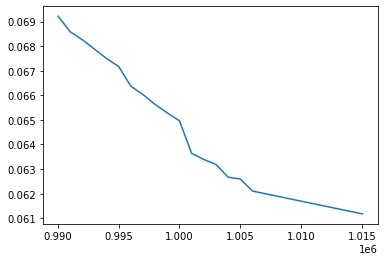

NGC 2366


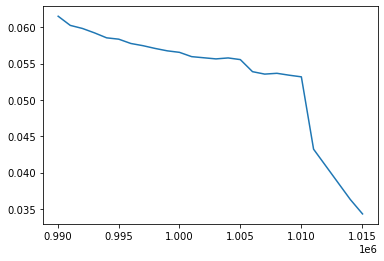

NGC 2403


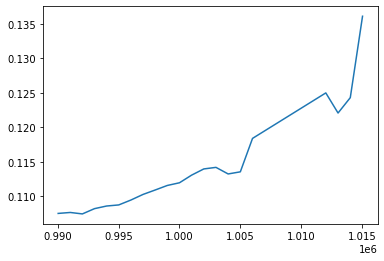

NGC 247


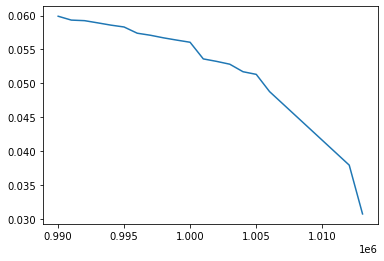

NGC 300


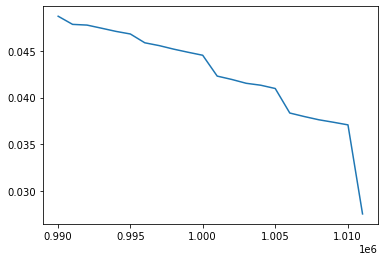

NGC 3109


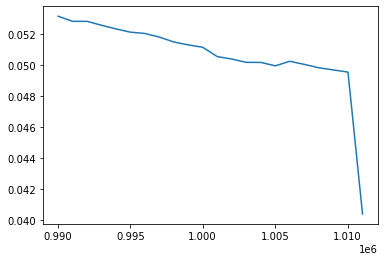

NGC 3741


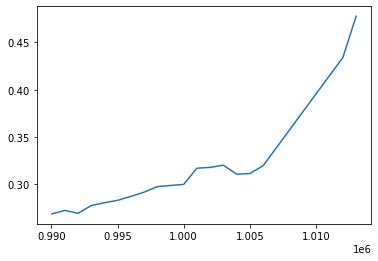

NGC 404


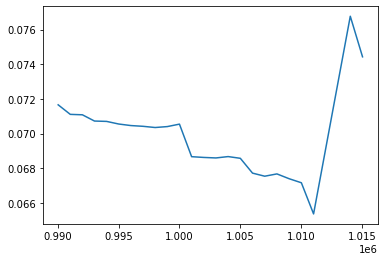

NGC 4163 (NGC 4167)


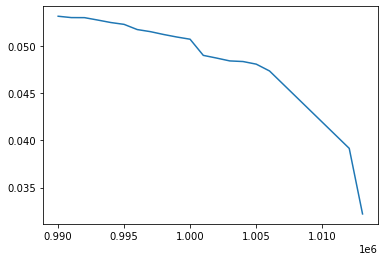

NGC 4214 (UGC 7278)


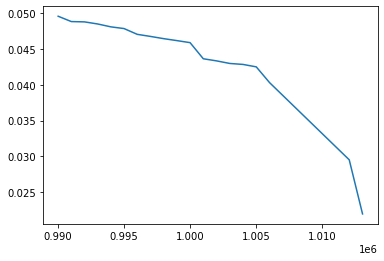

NGC 5102


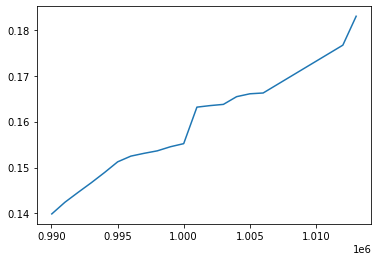

NGC 5206


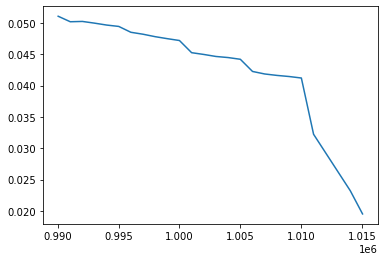

NGC 5237


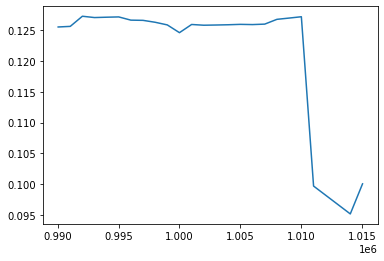

NGC 5253


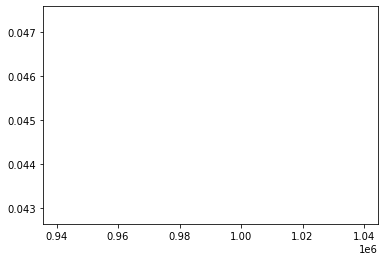

NGC 55


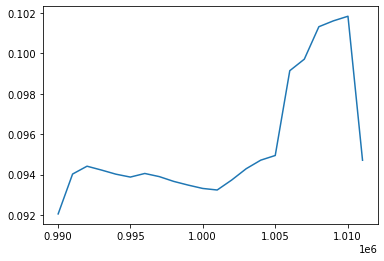

Pegasus Dwarf Irregular (DDO 216)


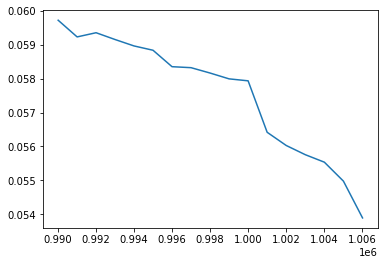

Pegasus Dwarf Sph (And VI)


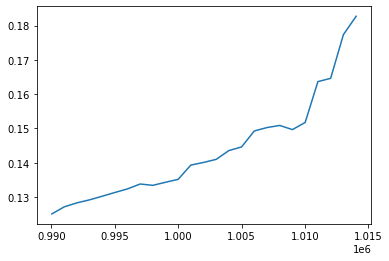

Pegasus III


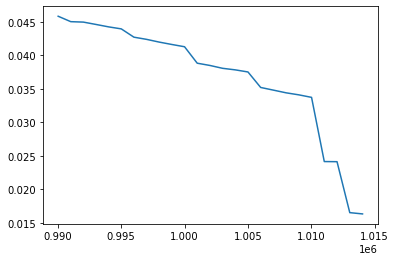

Perseus I (Andromeda XXXIII)


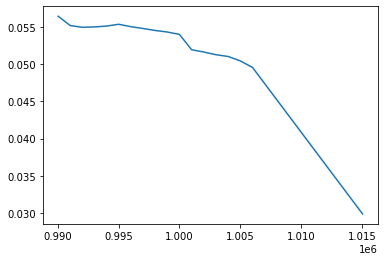

Phoenix Dwarf Galaxy (P 6830)


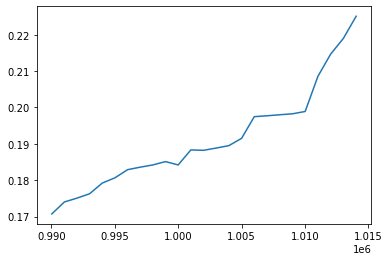

Phoenix II


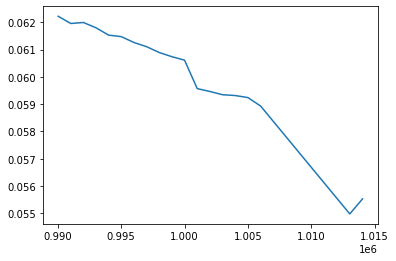

Pictor II


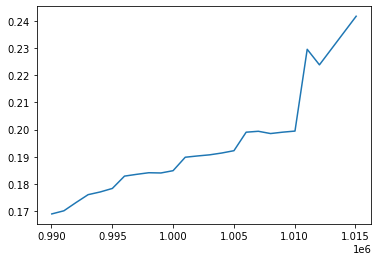

Pisces Dwarf


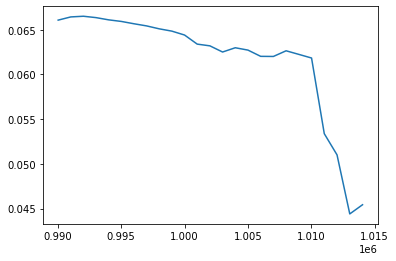

Pisces I


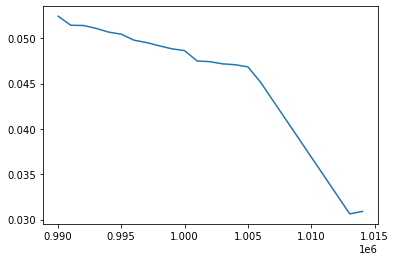

Pisces II


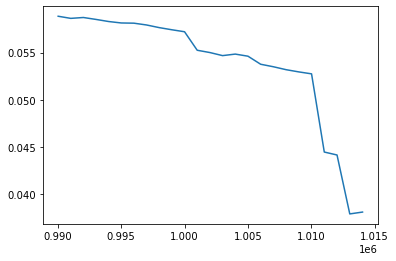

Pisces III (Andromeda XIII)


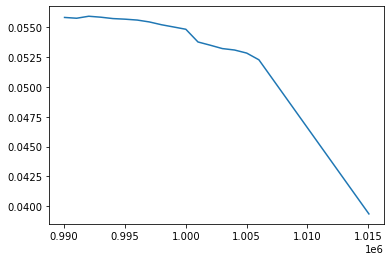

Pisces IV (Andromeda XIV)


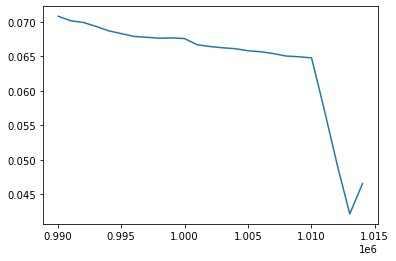

Pisces V (Andromeda XVI)


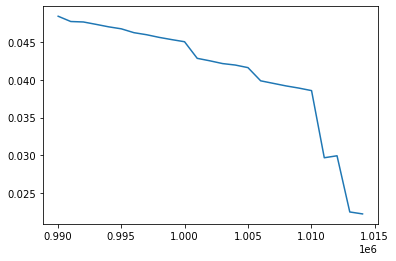

Reticulum II


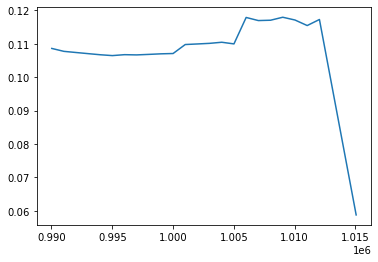

Reticulum III


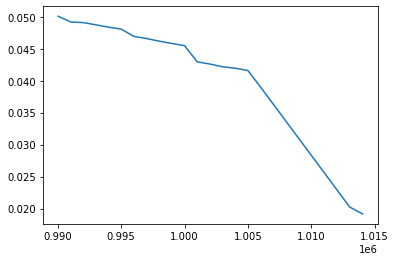

Sagittarius Dwarf Irregular Galaxy (SagDIG)


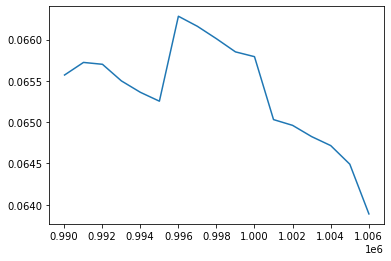

Sagittarius Dwarf Sphr SagDEG


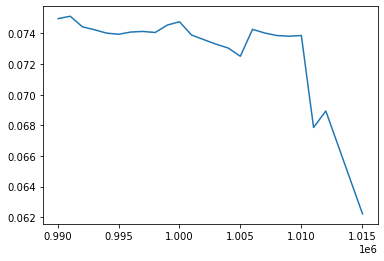

Sagittarius II


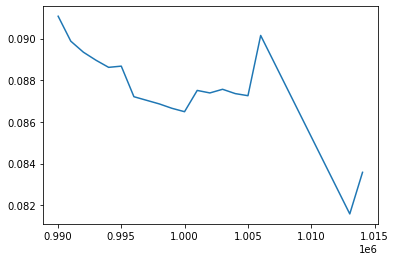

Sculptor Dwarf (E351-G30)


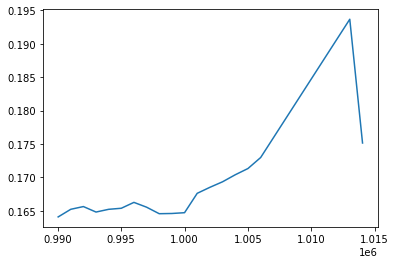

Segue 1


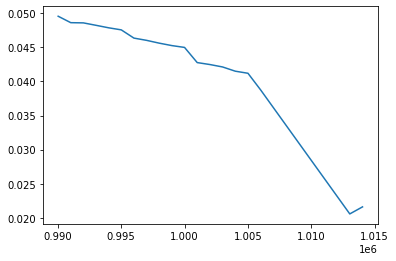

Segue 2


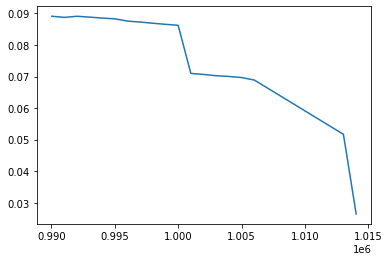

Sextans A (92205, DDO 75)


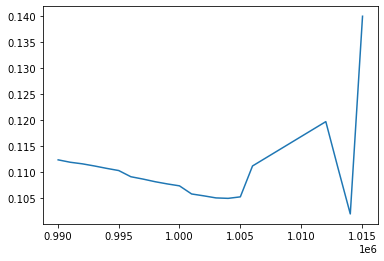

Sextans B (UGC 5373)


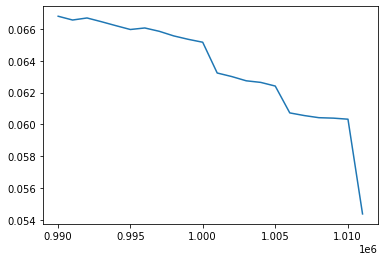

Sextans Dwarf Sph


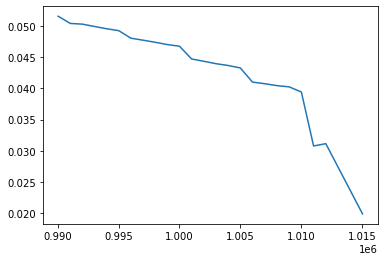

Small Magellanic Cloud (SMC, NGC 292)


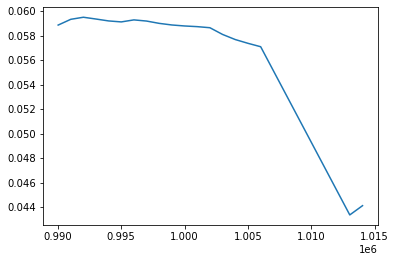

Triangulum Galaxy (M33)


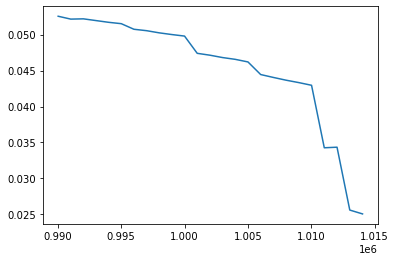

Triangulum II


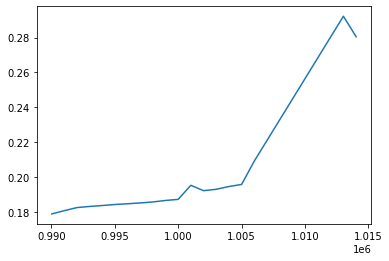

Tucana Dwarf


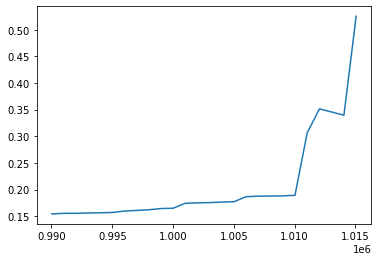

Tucana II


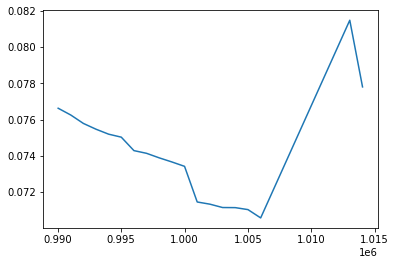

Tucana III


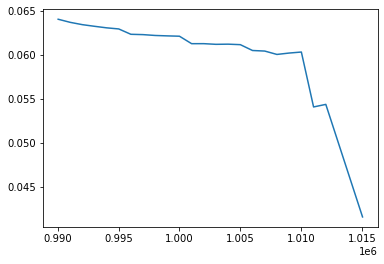

Tucana IV


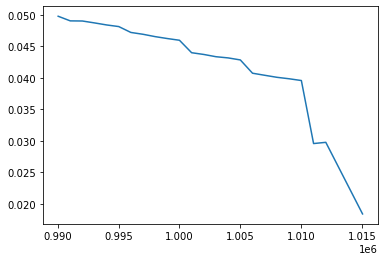

UGC 4483


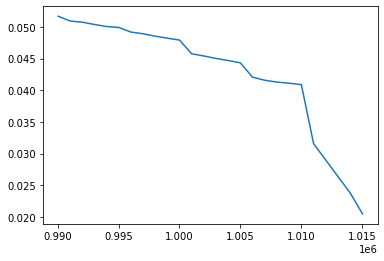

UGC 4879 (VV124)[61]


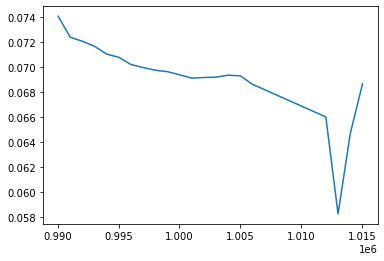

UGC 7577 (DDO 125)


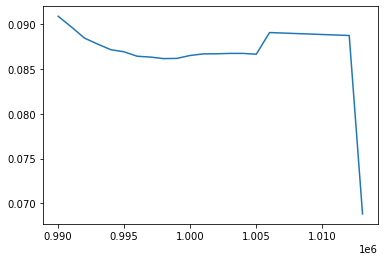

UGC 8508 (I Zw 060)


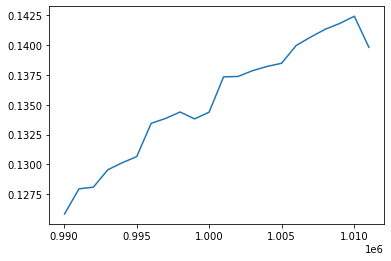

UGC 8651 (DDO 181)


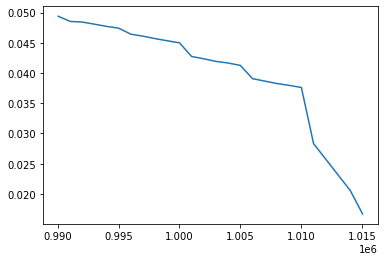

UGC 8833


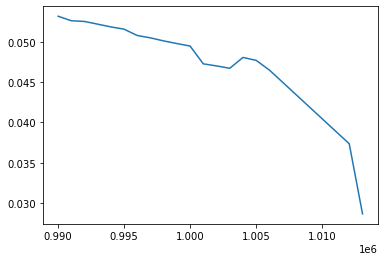

UGC 9128 (DDO 187)


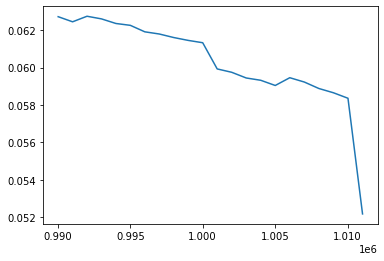

UGC 9240 (DDO 190)


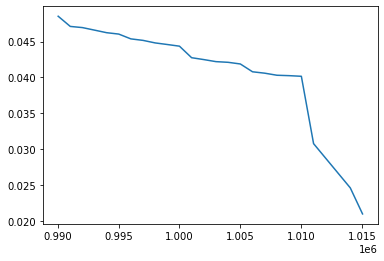

UGCA 105


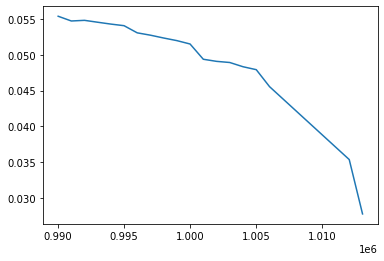

UGCA 133 (DDO 44)


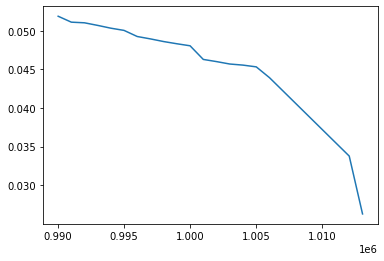

UGCA 15 (DDO 6)


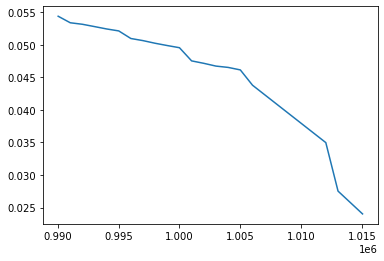

UGCA 276 (DDO 113)


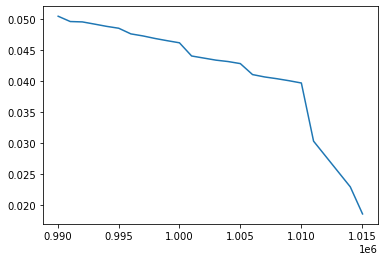

UGCA 292


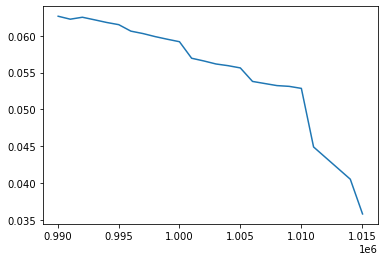

UGCA 438 (ESO 407-018)


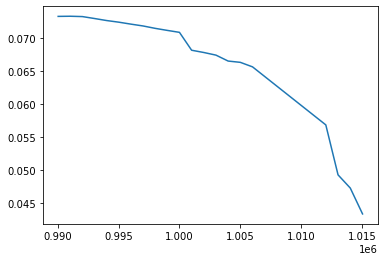

UGCA 86


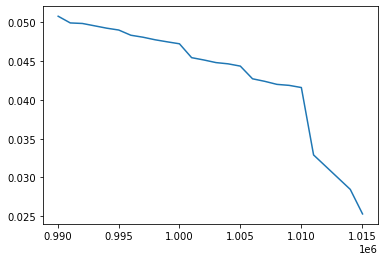

UGCA 92


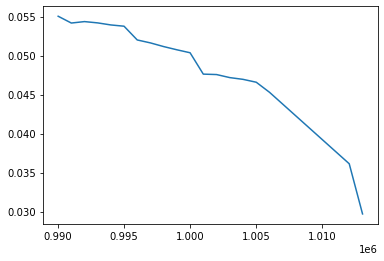

Ursa Major I Dwarf (UMa I dSph)


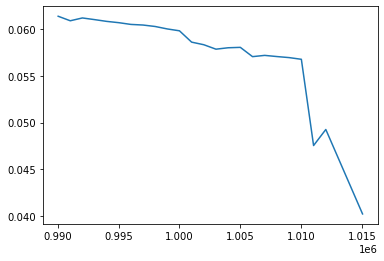

Ursa Major II Dwarf


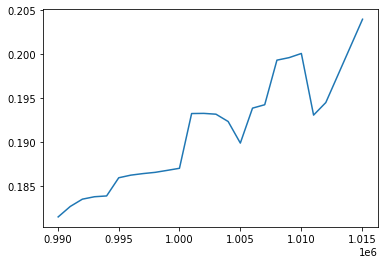

Ursa Minor Dwarf


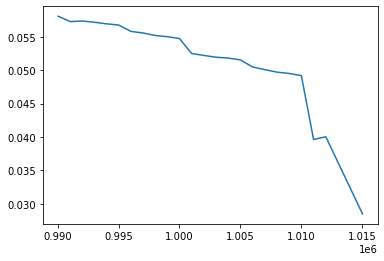

Virgo I


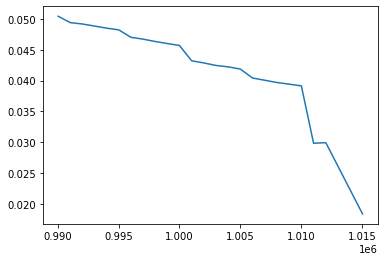

Willman 1


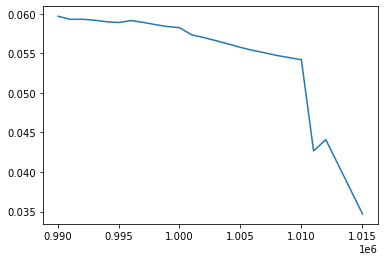

Wolf-Lundmark-Melotte (WLM, DDO 221)


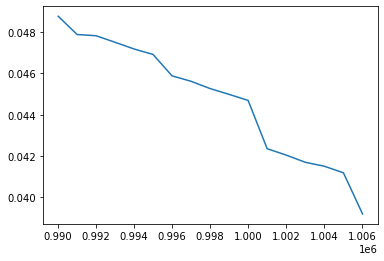

In [12]:
for name,grp in all_df.groupby("galaxy"):
  print(name)
  plt.plot(grp["galactic year"],grp.y)
  plt.show()

In [13]:
def fill_na_mean_grp(df,cols):                     #Handling Missing values
  # Fill grp with interpol + mean of group
  cols.remove("galaxy")
  for col in cols:
    df[col] = df.groupby("galaxy")[col].transform(lambda x: x.interpolate(method="linear",limit_direction="both"))
    # filling left nan with mean of galaxy
    df[col] = df.groupby("galaxy")[col].transform(lambda x: x.fillna(x.mean()))
  return df

In [14]:
all_df = fill_na_mean_grp(all_df,all_df.columns.to_list())

print(all_df.isna().sum())

index                                                                           0
galactic year                                                                   0
galaxy                                                                          0
existence expectancy index                                                      1
existence expectancy at birth                                                   1
                                                                             ... 
Adjusted net savings                                                          493
Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total    1185
Private galaxy capital flows (% of GGP)                                       441
Gender Inequality Index (GII)                                                 471
y                                                                               0
Length: 81, dtype: int64


In [15]:
def rem_neg_values(df,cols):              #Dealing with outliers
  cols.remove("galaxy")
  for col in cols:
    df[col] = df[col].clip(lower=0)
  return df                                                                        

In [16]:
all_df = rem_neg_values(all_df,all_df.columns.to_list())


In [17]:
from sklearn.preprocessing import LabelEncoder       #Dealing with the "Galaxy" feature


def one_hot_encode(df):
  return pd.get_dummies(df)

def label_encode(df):
  galaxies = df["galaxy"]
  le = LabelEncoder()
  df["gal_cat"] = le.fit_transform(galaxies)
  return df

In [18]:
all_df1 = one_hot_encode(all_df)

In [ ]:
#Imputation runs for a very long time, so we comment out the code below and upload the final result
# train_ae = train.drop('galaxy', axis=1)
# imputed_training = ae(train_to_ae.values)
# train_ae = pd.DataFrame(data=imputed_training, columns=train_to_ae.columns.tolist())

In [19]:
train_ae = pd.read_csv("encoded_train.csv")
test_ae = pd.read_csv("encoded_test.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'encoded_train.csv'

In [20]:
X = train_ae.drop(["y",'galaxy'],1)
y = train_ae["y"]
X_train,X_test,y_train,y_test = train_test_split(X,y) 

NameError: name 'train_ae' is not defined

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RidgeCV
estimators_1 = [
    ('xgb', XGBRegressor(gamma= 0.5,learning_rate= 0.2,max_depth= 3,min_child_weight= 1,objective ='reg:squarederror')),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(bootstrap= True,max_depth= 20,max_features= 8,min_samples_leaf= 3,min_samples_split= 2,n_estimators= 300)),
    ('lgb', LGBMRegressor(learning_rate=0.1,max_depth=3,num_leaves=10,min_child_sample=1)),
    ('lasso', Lasso(alpha=0.047)),
    ('knnr', KNeighborsRegressor()),
    ('cat', CatBoostRegressor(logging_level='Silent',learning_rate=0.03)),
    ( 'ExtraTR',ExtraTreesRegressor(n_estimators=110,max_depth=10 )),
]

stack = StackingTransformer(estimators_1, regression=True, verbose=2, shuffle=True)
stack = stack.fit(X_train, y_train)
S_train = stack.transform(X_train)


final_estimator = CatBoostRegressor(n_estimators=1500, max_depth=5,learning_rate=0.02)
final_estimator = final_estimator.fit(S_train, y_train)

S_test = stack.transform(new_test.drop('galaxy',1))
pred = final_estimator.predict(S_test)
y_1 = pred

NameError: name 'KNeighborsRegressor' is not defined

In [22]:
We are using a fine tuned XGBoost model for our stacking

train_2 = all_df1[:len(train)]
test_2 = all_df[len(train):]

SyntaxError: invalid syntax (<ipython-input-22-1c109f9d4b66>, line 1)

In [23]:
X2 = train_2.drop(["y"],1)
y2 = train_2["y"]

NameError: name 'train_2' is not defined

In [24]:
print(X2.shape)

NameError: name 'X2' is not defined

In [25]:
from sklearn.model_selection import train_test_split
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.25)

NameError: name 'X2' is not defined

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

estimators_1 = [
    #('xgb', XGBRegressor(objective ='reg:squarederror')),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(max_depth=20,max_features=8,min_samples_leaf=3,min_samples_split=8,n_estimators=100)),
    ('lgb', LGBMRegressor(max_depth=5,num_leaves=30,min_data_in_leaf=5)),
    ('svr', SVR()),
    ('lasso', Lasso()),
    ('cat', CatBoostRegressor(logging_level='Silent',max_depth=5,learning_rate=0.03,n_estimators=1000)),
 
]

stack = StackingTransformer(estimators_1, regression=True, verbose=2, shuffle=True)
stack = stack.fit(X_train2, y_train2)
S_train = stack.transform(X_train2)


final_estimator = XGBRegressor()
final_estimator = final_estimator.fit(S_train, y_train2)

S_test = stack.transform(test_2)

pred = final_estimator.predict(S_test)
y2 = pred

In [29]:
# Creating thenew features

def get_stats_features(grp,cols=[]):
  cols = grp.columns.to_list()
  cols.remove("galaxy")
  for col in cols:
    grp[col + "_mean"]= grp[col].mean()
    grp[col + "_max"] = grp[col].max()
    grp[col + "_min"] = grp[col].min()
    grp[col + "_std"] = grp[col].std()
  return grp

all_df3 = all_df.groupby("galaxy",group_keys=False).apply(get_stats_features)

In [ ]:
train_3 = all_df3[:len(train)]
test_3  all_df3[len(train):]

In [30]:
X3 = new_train3.drop("y",1)
y3 = new_train3["y"]

NameError: name 'new_train3' is not defined

In [ ]:
X_train3,X_test3,y_train3,y_test3 = train_test_split(X3,y3,test_size=0.25,random_state=0)

In [26]:
# Building the 3rd model

estimators_1 = [
    ('xgb', XGBRegressor(objective ='reg:squarederror')),
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor()),
    ('lgb', LGBMRegressor(max_depth=5,num_leaves=30,min_data_in_leaf=5)),
    ('svr', SVR()),
]

stack = StackingTransformer(estimators_1, regression=True, verbose=2, shuffle=True)
stack = stack.fit(X_train3, y_train3)
S_train = stack.transform(X_train3)

final_estimator = XGBRegressor(max_depth=3,learning_rate=0.1,n_estimators=1000)
final_estimator = final_estimator.fit(S_train, y_train)

NameError: name 'X_train3' is not defined

In [27]:
S_test = stack.transform(test_3)

pred = final_estimator.predict(S_tes)
y3 = pred

NameError: name 'test_3' is not defined

In [28]:
y_result = np.power(y1*y2*y3,1/3)

NameError: name 'y1' is not defined

In [31]:
index = ss['pred']
pot_inc = -np.log(index+0.01)+3
p2= pot_inc**2
ss["p2"] = p2

NameError: name 'ss' is not defined

In [32]:
#Sorting using Likelyincreasing index
ss=ss.sort_values('p2',ascending=False)
#Droping The old index 
ss=ss.reset_index(drop=True)

NameError: name 'ss' is not defined

In [33]:
ss


NameError: name 'ss' is not defined

In [34]:
y_pred=ss.pred
x = np.arange(y_pred.min(),y_pred.max(),0.01)
plt.figure(figsize=(25,10))
plt.hist(y_pred,bins=x)
plt.title('Y_pred Histogram',fontsize=20)
plt.xlabel('y_pred',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(x)
plt.show()

NameError: name 'ss' is not defined

In [35]:
n = 340
#Giving the max of Energy to the 340 first element (ordered using the likely Increasing Index)
ss.opt_pred[:n]=100
ss.opt_pred[n:] = 0
c=100
alpha = 0.62685
for i in range(n,374):
  if c>=alpha: 
    c=c-alpha
    ss.loc[i,'opt_pred'] =c
alpha=0.067345
for i in range(374,455):
  if c>=alpha: 
    c=c-alpha
    ss.loc[i,'opt_pred'] =c
  else:
    ss.loc[i,'opt_pred'] = 0
alpha = 0.03
for i in range(455,465):
  if c>=alpha: 
    c=c-alpha
    ss.loc[i,'opt_pred'] =c
alpha=0.4339465
for i in range(465,890):
  if c>=alpha: 
    c=c-alpha
    ss.loc[i,'opt_pred'] =c
  else:
    ss.loc[i,'opt_pred'] = 0

print(ss.opt_pred.sum())

NameError: name 'ss' is not defined

In [36]:
#Checking if the sum of opt_pred in rows having eei<0.7 is >5000
print("sum",ss.opt_pred.sum())
print("left", (50000-ss.opt_pred.sum())) 
print("eei Sum",ss[ss.eei<0.7]['opt_pred'].sum())

NameError: name 'ss' is not defined

In [37]:
# Plot opt pred vs y
plt.plot(ss.pred)
plt.plot(ss.opt_pred/100,color="red")
plt.show()

NameError: name 'ss' is not defined

In [38]:
#We aren't so sure that allocating 100 Zillion DSML to the 340 first rows is optimal  
ss.opt_pred=0
n = 340
ss.opt_pred[:n]=100
ss.opt_pred[n:] = 0
c=100
#This is a simple test we could add more steps or maybe changing these one
for i in range(n,890):
  if ss.pred[i]-ss.pred[i-1]<4*10**(-6):
    alpha=0.13
  if ss.pred[i]-ss.pred[i-1]>=4*10**(-6) and ss.pred[i]-ss.pred[i-1]<4*10**(-5):
    alpha=0.21222895
  if ss.pred[i]-ss.pred[i-1]>=4*10**(-5) and ss.pred[i]-ss.pred[i-1]<10**(-4):
    alpha=0.33
  if ss.pred[i]-ss.pred[i-1]>=10**(-4) and ss.pred[i]-ss.pred[i-1]<5*10**(-3) :
    alpha=0.48
  if ss.pred[i]-ss.pred[i-1]>=5*10**(-3) and ss.pred[i]-ss.pred[i-1]<10**(-3):
    alpha=0.58
  if ss.pred[i]-ss.pred[i-1]>=10**(-3):
    alpha=0.73
  c-=alpha
  if c-alpha>0:
    ss.loc[i,'opt_pred'] =c
  else:
    ss.loc[i,'opt_pred'] =0

print(ss.opt_pred.sum())

NameError: name 'ss' is not defined

In [39]:
#Checking if the sum of opt_pred in rows having eei<0.7 is >5000
print("sum",ss.opt_pred.sum())
print("left", (50000-ss.opt_pred.sum()))
print("eei",ss[ss.eei<0.7]['opt_pred'].sum())

NameError: name 'ss' is not defined

In [40]:
plt.plot(ss.pred)
plt.plot(ss.opt_pred/100,color="red")
plt.show()

NameError: name 'ss' is not defined

In [41]:
#Reordering the list using the real index
ss=ss.sort_values('Index',ascending=True)
ss=ss.reset_index(drop=True)

NameError: name 'ss' is not defined

In [42]:
ss[['Index', 'pred', 'opt_pred']].to_csv('sub.csv', index=False)

NameError: name 'ss' is not defined